# Google Drive
The following code mounts your Google drive for use with Google CoLab. If you are not using CoLab, the following code will not work.

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False
    
%cd drive/My Drive/phylum/bacteria/Compositional-Agents/classification/

Mounted at /content/drive
Note: using Google CoLab
/content/drive/My Drive/phylum/bacteria/Compositional-Agents/classification


#imports
The following packages will be used to implement our ml model

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from sklearn.metrics import confusion_matrix

import os
import random
import fnmatch

# configuration & model implementation

In [4]:
# settings for reproducibility
SEED = 42
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [5]:
# === CONFIGURATION ===
# list of labels
# catergorical data to be converted to numerical data via one-hot encoding
# SWARM_LABELS = ["swirl", "snake"]
# Generation resolution - Must be square
# Training data is also scaled to this.
GENERATE_SQUARE = 224  # size of vgg16 input
IMAGE_CHANNELS = 3

# epochs, batch size and location of dataset
DATA_PATH = "data/swarming"  # '/content/drive/My Drive/research/deep_learning/GDL_code/data/bacteria/'
EPOCHS = 20
BATCH_SIZE = 16

print(f"Will generate {GENERATE_SQUARE}px square images.")

# run params
SECTION = 'vgg16'
RUN_ID = '0000'
DATA_NAME = 'swarming'
MODEL_FOLDER = 'models/{}/'.format(SECTION)
MODEL_FOLDER += '_'.join([RUN_ID, DATA_NAME])  # where to save the models
print(MODEL_FOLDER)

if not os.path.exists(MODEL_FOLDER):
    os.makedirs(MODEL_FOLDER)
    os.mkdir(os.path.join(MODEL_FOLDER, 'weights'))

Will generate 224px square images.
models/vgg16/0000_swarming


In [6]:
# === PREPARE THE TRAINING DATA ===
# perform data augmentation to expand the size of the dataset
train_gen = ImageDataGenerator(rotation_range=15,  # rotate the image 15 degrees
                               width_shift_range=0.05,  # Shift the pic width by a max of 5%
                               height_shift_range=0.05,  # Shift the pic height by a max of 5%
                               rescale=1/255,  # normalize pixel values.
                               shear_range=0.05,  # Shear means cutting away part of the image (max 5%)
                               zoom_range=0.05,  # Zoom in by 5% max
                               brightness_range=[0.75, 1.25],  # alter brightness
                               horizontal_flip=True,  # Allow horizontal flipping
                               vertical_flip=True,  # Allow vertical flipping
                               preprocessing_function=vgg16.preprocess_input,
                               fill_mode='nearest'  # Fill in missing pixels with the nearest filled value
                               )

# Use flow_from_directory, to set up train and text images
# The directories should only contain images of one class
# so one folder per class of images (e.g. 'train/snakes', 'train/swirls', etc).
train_dir = './data/' + DATA_NAME + '/train'

# generate batches of train images and labels
train_generator = train_gen.flow_from_directory(
    train_dir,
    target_size=(GENERATE_SQUARE, GENERATE_SQUARE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    class_mode='binary')

train_generator.class_indices

Found 238 images belonging to 2 classes.


{'snakes': 0, 'swirls': 1}

The shape of train images: (224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Class name: snakes')

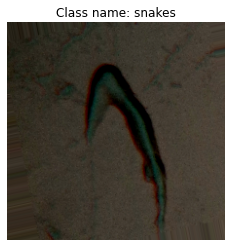

In [7]:
# === VISUALIZE THE TRAINING DATASET ===
# from the tensrflow documentation for flow_from_directory:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory
# returns s DirectoryIterator yielding tuples of (x, y) where x is a numpy array containing a batch of images with shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels.

# randomly choose the image index for the visualization (i.e. which tuple?)
image_id = random.randint(0, len(train_generator) - 1)

# get the train image shape
print("The shape of train images: {}".format(train_generator[image_id][0][0].shape))

# visualize the image example
plt.axis('off')
plt.imshow(train_generator[image_id][0][0])

# get image class and map its index with the names of the classes
train_image_label_id = train_generator[image_id][1][0].astype(int)
classes_list = list(train_generator.class_indices.keys())

# show image class
plt.title("Class name: {}".format(classes_list[train_image_label_id]))


In [8]:
# === PREPARE THE TEST/VALIDATION DATA ===
# generate batches of validation images and labels
test_gen = ImageDataGenerator(rescale=1/255)

test_dir = './data/' + DATA_NAME + '/test'

validation_generator = test_gen.flow_from_directory(
    test_dir,
    target_size=(GENERATE_SQUARE, GENERATE_SQUARE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=SEED)

Found 61 images belonging to 2 classes.


The shape of validation images: (224, 224, 3)


Text(0.5, 1.0, 'Class name: snakes')

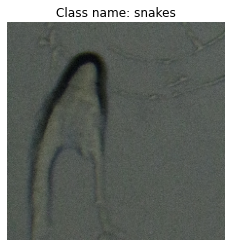

In [9]:
# === VISUALIZE THE TEST/VALIDATION DATASET ===

# randomly choose the image index for the visualization
val_image_id = image_id = random.randint(0, len(validation_generator) - 1)

# get the validation image shape
print("The shape of validation images: {}".format(validation_generator[val_image_id][0][0].shape))

# visualize the image example
plt.axis('off')
plt.imshow(validation_generator[val_image_id][0][0])

# get image class and map its index with the names of the classes
val_image_label_id = validation_generator[val_image_id][1][0].astype(int)
classes_list = list(validation_generator.class_indices.keys())

# show image class
plt.title("Class name: {}".format(classes_list[val_image_label_id]))

In [10]:
# === INITIALIZE THE MODEL ===
# Initialize the VGG16 model, pre-trained with Imagenet weights
# set include_top parameter to False in order to exclude the fully-connected layers at the top of the network.
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(GENERATE_SQUARE, GENERATE_SQUARE, IMAGE_CHANNELS))

model = Sequential()
model.add(vgg_conv)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:
# === TRAIN THE MODEL ===
# let's reduce the learning rate a bit first
# https://keras.io/api/callbacks/reduce_lr_on_plateau/
#lr_adjust = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.75, patience=3, verbose=0, mode="auto", min_delta=0.001, cooldown=0, min_lr=0)
#results = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, callbacks=[lr_adjust])
results = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator)

Epoch 1/20
15/15 [==============================] - 253s 15s/step - loss: 0.4277 - accuracy: 0.7857 - val_loss: 0.3582 - val_accuracy: 0.8033
Epoch 2/20
15/15 [==============================] - 18s 1s/step - loss: 0.1498 - accuracy: 0.9538 - val_loss: 0.4349 - val_accuracy: 0.7705
Epoch 3/20
15/15 [==============================] - 18s 1s/step - loss: 0.1042 - accuracy: 0.9706 - val_loss: 0.3255 - val_accuracy: 0.7869
Epoch 4/20
15/15 [==============================] - 18s 1s/step - loss: 0.0767 - accuracy: 0.9832 - val_loss: 0.2408 - val_accuracy: 0.8689
Epoch 5/20
15/15 [==============================] - 18s 1s/step - loss: 0.0738 - accuracy: 0.9748 - val_loss: 0.2139 - val_accuracy: 0.9180
Epoch 6/20
15/15 [==============================] - 18s 1s/step - loss: 0.0610 - accuracy: 0.9832 - val_loss: 0.2823 - val_accuracy: 0.8689
Epoch 7/20
15/15 [==============================] - 18s 1s/step - loss: 0.0455 - accuracy: 0.9832 - val_loss: 0.2699 - val_accuracy: 0.8689
Epoch 8/20
15/15 [

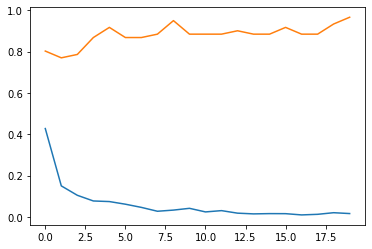

In [13]:
# === EVALUATE THE MODEL ===
# plot loss and validation accuracy
plt.plot(results.history['loss'])
plt.plot(results.history['val_accuracy'])

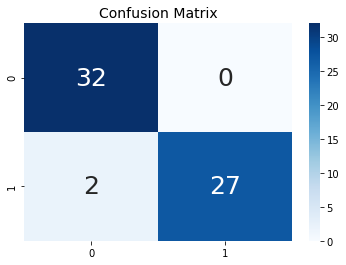

In [14]:
# confusion matrix
Y_pred = model.predict(validation_generator)
y_pred = [0 if x < 0.5 else 1 for x in Y_pred]
cm = confusion_matrix(validation_generator.classes, y_pred)
cm_ax = plt.axes()
sb.heatmap(cm, annot=True,annot_kws={"size": 25}, cmap="Blues", ax=cm_ax)
cm_ax.set_title('Confusion Matrix', size=14)
plt.show()

class: 0 (snakes)
Probability that the image ./data/swarming/test/snakes/06_2021-08-19_235105.jpg is a snake: 0.9991986234090291 


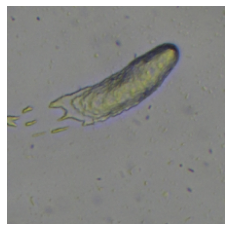

In [15]:
# === PREDICTION ===
# get the number of files in the snakes test directory
snakes = fnmatch.filter(os.listdir(test_dir + '/snakes/'), '*.jpg')
# select one of the files randomly
snake = test_dir + '/snakes/' + random.choice(snakes)
snake_img = image.load_img(snake, target_size=(GENERATE_SQUARE, GENERATE_SQUARE))
# show image
plt.axis('off')
plt.imshow(snake_img)
snake_img = image.img_to_array(snake_img)
# remember that we need to preprocess the images as the vgg16 model needs it (just like we did for training).
snake_img = vgg16.preprocess_input(snake_img)
snake_img = np.expand_dims(snake_img, axis=0)
snake_img = snake_img/255
prediction_prob = model.predict(snake_img)

# Output prediction
idx = np.where(prediction_prob  > 0.5, 1,0)
idx = idx[0][0]
print("class: " + str(idx) + " (" + classes_list[idx] + ")")
print(f'Probability that the image {snake} is a snake: {1 - prediction_prob[0][0]} ')


class: 1 (swirls)
Probability that the image ./data/swarming/test/swirls/10_2021-08-17_180213.jpg is a swirl: 0.9437195658683777 


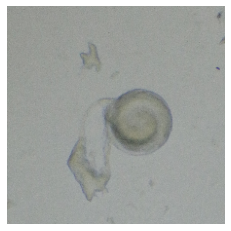

In [16]:
# get the number of files in the snakes test directory
swirls = fnmatch.filter(os.listdir(test_dir + '/swirls/'), '*.jpg')
# select one of the files randomly
swirl = test_dir + '/swirls/' + random.choice(swirls)
swirl_img = image.load_img(swirl, target_size=(GENERATE_SQUARE, GENERATE_SQUARE))
# show image
plt.axis('off')
plt.imshow(swirl_img)
swirl_img = image.img_to_array(swirl_img)
# remember that we need to preprocess the images as the vgg16 model needs it (just like we did for training).
swirl_img = vgg16.preprocess_input(swirl_img)
swirl_img = np.expand_dims(swirl_img, axis=0)
swirl_img = swirl_img/255
prediction_prob = model.predict(swirl_img)

# Output prediction
idx = np.where(prediction_prob  > 0.5, 1,0)
idx = idx[0][0]
print("class: " + str(idx) + " (" + classes_list[idx] + ")")
print(f'Probability that the image {swirl} is a swirl: {prediction_prob[0][0]} ')

In [17]:
# === SAVE THE MODEL ===
model.save(os.path.join(MODEL_FOLDER, 'model'))
model.save_weights(os.path.join(MODEL_FOLDER + '/weights/', 'weights'), save_format="tf")

# save a frozen graph - which is needed for prpoper infereceing (prediction) in oepn cv
# https://leimao.github.io/blog/Save-Load-Inference-From-TF2-Frozen-Graph/
# https://stackoverflow.com/questions/62288678/save-pb-and-pbtxt-file-from-keras?rq=1
# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 50)
print("Frozen model layers: ")
for layer in layers:
    print(layer)

print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=MODEL_FOLDER + "/frozen_model/",
                  name="frozen_graph.pb",
                  as_text=False)


INFO:tensorflow:Assets written to: models/vgg16/0000_swarming/model/assets
--------------------------------------------------
Frozen model layers: 
x
sequential/vgg16/block1_conv1/Conv2D/ReadVariableOp/resource
sequential/vgg16/block1_conv1/Conv2D/ReadVariableOp
sequential/vgg16/block1_conv1/Conv2D
sequential/vgg16/block1_conv1/BiasAdd/ReadVariableOp/resource
sequential/vgg16/block1_conv1/BiasAdd/ReadVariableOp
sequential/vgg16/block1_conv1/BiasAdd
sequential/vgg16/block1_conv1/Relu
sequential/vgg16/block1_conv2/Conv2D/ReadVariableOp/resource
sequential/vgg16/block1_conv2/Conv2D/ReadVariableOp
sequential/vgg16/block1_conv2/Conv2D
sequential/vgg16/block1_conv2/BiasAdd/ReadVariableOp/resource
sequential/vgg16/block1_conv2/BiasAdd/ReadVariableOp
sequential/vgg16/block1_conv2/BiasAdd
sequential/vgg16/block1_conv2/Relu
sequential/vgg16/block1_pool/MaxPool
sequential/vgg16/block2_conv1/Conv2D/ReadVariableOp/resource
sequential/vgg16/block2_conv1/Conv2D/ReadVariableOp
sequential/vgg16/block2_

'models/vgg16/0000_swarming/frozen_model/frozen_graph.pb'